# Workflow to Validate NISAR L2 Secular Displacement Requirement

**Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun 

Extensive modifications by Adrian Borsa and Amy Whetter 2022

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>



## Define CalVal Site 

In [1]:
# Choose a site and track direction
# Available secular displacement validation sites: 
#        RidgecrestA64 : 2019 Ridgecrest Earthquakes in California ascending track 64
#        CentralValleyA144 : Central Valley in California Sentinel-1 track 144  
#        MojaveD173 : Eastern Mojave Desert in California Sentinel-1 track 173  

site='MojaveD173'  

## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#secular_prep_a)

[**Prep B. Data Staging**](#secular_prep_b)

[**1. Generate Interferogram Stack**](#secular_gen_ifg)
- [1.1.  Crop Interferograms](#secular_crop_ifg)

[**2. Generation of Time Series from Interferograms**](#secular_gen_ts)
- [2.1. Set Up MintPy Configuration file](#secular_setup_config)
- [2.2. Load Data into MintPy](#secular_load_data)
- [2.3. Validate/Modify Interferogram Network](#secular_validate_network)
- [2.3. Generate Quality Control Mask](#secular_generate_mask)
- [2.4. Reference Interferograms To Common Lat/Lon](#secular_common_latlon)
- [2.5. Invert for SBAS Line-of-Sight Timeseries](#secular_invert_SBAS)

[**3. Optional Corrections**](#secular_opt_correction)
- [3.1. Solid Earth Tides Correction](#secular_solid_earth)
- [3.2. Tropospheric Delay Correction](#secular_tropo_corr)
- [3.3. Phase Deramping ](#secular_phase_deramp)
- [3.4. Topographic Residual Correction ](#secular_topo_corr) 

[**4. Estimate InSAR and GNSS Velocities**](#secular_decomp_ts)
- [4.1. Estimate InSAR LOS Velocities](#secular_insar_vel1)
- [4.2. Find Collocated GNSS Stations](#secular_co_gps)  
- [4.3. Get GNSS Position Time Series](#secular_gps_ts) 
- [4.4. Make GNSS LOS Velocities](#secular_gps_los)
- [4.5. Re-Reference GNSS and InSAR Velocities](#secular_gps_insar)

[**5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#secular_nisar_validation)
- [5.1. Make Velocity Residuals at GNSS Locations](#secular_make_vel)
- [5.2. Make Double-differenced Velocity Residuals](#secular_make_velres)
- [5.3. Secular Requirement Validation: Method 1](#secular_valid_method1)

[**6. NISAR Validation Approach 2: InSAR-only Structure Function**](#secular_nisar_validation2)

[**7. Appendix: Supplementary Comparisons and Plots**](#secular_appendix1)
- [7.1. Compare Raw Velocities](#secular_compare_raw)
- [7.2. Plot Velocity Residuals](#secular_plot_vel)
- [7.3. Plot Double-differenced Residuals](#secular_plot_velres)
- [7.4. GPS Position Plot](#secular_appendix_gps)

<hr/>

<a id='secular_prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [2]:
#Load Packages
import os
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import pickle
from scipy import signal
from datetime import datetime as dt
from solid_utils.sampling import load_geo, samp_pair

#Verify MintPy Installation
try:
    from mintpy.objects import gps
    from mintpy.utils import ptime, time_func, readfile, utils as ut
    from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except ImportError:
    raise ImportError("Looks like MintPy is not fully installed")

from matplotlib import pyplot as plt
#Set Global Plot Parameters
plt.rcParams.update({'font.size': 12})

################# Set Directories ##########################################
print('\nCurrent directory:',os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()/'work'/'secular_ouputs'/site

print("Work directory:", work_dir)
work_dir.mkdir(parents=True, exist_ok=True)
# Change to Workdir   
os.chdir(work_dir)
       
gunw_dir = work_dir/'products'
gunw_dir.mkdir(parents=True, exist_ok=True)
print("   GUNW    dir:", gunw_dir) 
    
mintpy_dir = work_dir/'MintPy' 
mintpy_dir.mkdir(parents=True, exist_ok=True)
print("   MintPy  dir:", mintpy_dir)
############################################################################
### List of CalVal Sites:
'''
Set NISAR calval sites:
    CentralValleyA144  : Central Valley
    OklahomaA107       : Oklahoma
    PuertoRicoD98      : Puerto Rico (Earthquake M6.4 on 20200107) - Descending track 
    PuertoRicoA135     : Puerto Rico (Earthquake M6.4 on 20200107 & large aftershock on 20200703) - Ascending track
    RidgecrestD71      : Ridgecrest  (Earthquake M7.2 on 20190705) - Descending track
    RidgecrestA64      : Ridgecrest  (Earthquake M7.2 on 20190705) - Ascending track
    MojaveD173

ARIA & MintPy parameters:
    calval_location : name
    download_region : download box in S,N,W,E format
    analysis_region : analysis box in S,N,W,E format (must be within download_region)
    download_start_date : download start date as YYYMMDD  
    download_end_date   : download end date as YYYMMDD
    earthquakeDate :  arbitrary date for testing with the central_valley dataset
    sentinel_track : sentinel track to download
    gps_ref_site_name : Name of the GPS site for InSAR re-referencing
    tempBaseMax' : maximum number of days, 'don't use interferograms longer than this value 
    ifgExcludeList : default is not to exclude any interferograms
    maskWater' :  interior locations don't need to mask water
'''
sites = {
    ##########  CENTRAL VALLEY ##############
    'CentralValleyA144' : {'calval_location' : 'Central_Valley',
            'download_region' : '"36.18 36.26 -119.91 -119.77"', # download box in S,N,W,E format
            'analysis_region' : '"35.77 36.75 -120.61 -118.06"', # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20180101',
            'download_end_date' : '20190101',
            'earthquakeDate' : '20180412',                       # arbitrary date for testing with the central_valley dataset
            'sentinel_track' : '144',
            'gps_ref_site_name' : 'CAWO',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},                       # reference site for this area
    ##########  OKLAHOMA ##############
    'OklahomaA107' : {'calval_location' : 'Oklahoma',
            'download_region' : '"31.7 37.4 -103.3 -93.5"',      # download box in S,N,W,E format
            'analysis_region' : '"35.25 36.5 -100.5 -98.5"',     # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20210101',
            'download_end_date' : '20210801',
            'earthquakeDate' : '20210328',                       # arbitrary date for testing with the Oklahoma dataset
            'sentinel_track' : '107',
            'gps_ref_site_name' : 'OKCL',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},
    ##########  PUERTO RICO ##############
    'PuertoRicoD98' : {'calval_location' : 'PuertoRicoDesc',
            'download_region' : '"17.5 18.9 -67.5 -66.0"',       # download box in S,N,W,E format
            'analysis_region' : '"17.9 18.5 -67.3 -66.2"',       # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20190701',
            'download_end_date' : '20200930',
            'earthquakeDate' : '20200107',                       # date of M6.4 quake
            'sentinel_track' : '98',                             # descending track
            'gps_ref_site_name' : 'PRLT',
            'tempBaseMax' : 24,                                  # don't use interferograms longer than 24 days
            'ifgExcludeList' : 'auto', 
            'maskWater' : True},                                 # need to mask ocean around Puerto Rico island
    'PuertoRicoA135' : {'calval_location' : 'PuertoRicoAsc',
             'download_region' : '"17.5 18.9 -67.5 -66.0"',      # download box in S,N,W,E format
             'analysis_region' : '"17.9 18.5 -67.3 -66.2"',      # analysis box in S,N,W,E format (must be within download_region)
             'download_start_date' : '20190701',
             'download_end_date' : '20200930',
             'earthquakeDate' : '20200107',                      # date of M6.4 quake
             'earthquakeDate2' : '20200703',                     # date of large aftershock
             'sentinel_track' : '135',                           # ascending track
             'gps_ref_site_name' : 'PRLT',
             'tempBaseMax' : 24,                                 # don't use interferograms longer than 24 days
             'ifgExcludeList' : 'auto',
             'maskWater' : True},                                # need to mask ocean around Puerto Rico island
    ##########  RIDGECREST ##############
    'RidgecrestD71': {'calval_location' : 'RidgecrestD71',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20190601',
                      'download_end_date' : '20190831',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '71',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False},
    'RidgecrestA64': {'calval_location' : 'Ridgecrest',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20190101',
                      'download_end_date' : '20190701',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '64',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'none',   # list of bad ifgs to exclude from time-series analysis
                      'maskWater' : False},
    ##########  MOJAVE ##############
    'MojaveD173': {'calval_location' : 'MojaveD173',
                      'download_region' : '"34.94 35.39 -115.94 -115.31"', # download box in S,N,W,E format
                      'analysis_region' : '"34.66 35.60 -116.62 -114.39"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20180101',
                      'download_end_date' : '20181231',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '173',
                      'gps_ref_site_name' : 'P619',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False}

}
secular_available_sites = ['RidgecrestA64','MojaveD173','CentralValleyA144']

if site not in secular_available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(secular_available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    for key, value in sites[site].items():
        print('   '+ key, ' : ', value)


Current directory: /Users/fielding/Downloads/ATBD
Work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173
   GUNW    dir: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/products
   MintPy  dir: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy

Selected site: MojaveD173
   calval_location  :  MojaveD173
   download_region  :  "34.94 35.39 -115.94 -115.31"
   analysis_region  :  "34.66 35.60 -116.62 -114.39"
   download_start_date  :  20180101
   download_end_date  :  20181231
   earthquakeDate  :  20190705
   sentinel_track  :  173
   gps_ref_site_name  :  P619
   tempBaseMax  :  auto
   ifgExcludeList  :  auto
   maskWater  :  False


<a id='secular_prep_b'></a>
## Prep B. Data Staging

In this initial processing step, all the necessary Level-2 unwrapped interferogram products are gathered, organized and reduced to a common grid for analysis with MintPy. Ascending and descending stacks of nearest-neighbor and skip-1 interferograms will be prepared for independent analysis. 

In [3]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = True
     
######### DO NOT CHANGE LINES BELOW ########

if Use_Staged_Data:
     # Check if a stage file from S3 already exist, if not try and download it
    if len(glob.glob('MintPy/inputs/*.h5')) == 0:
        os.chdir(work_dir.parents[0])
        zip_name = site + '.zip'
        print('Downloading:',  Path.cwd()/zip_name)
        if not os.path.isfile(zip_name):
            try:
                command = "aws s3 cp --no-sign-request s3://asf-jupyter-data-west/NISAR_SE/" + site + '.zip ' + zip_name
                subprocess.run(command, shell=True, check = True)
            except:
                command = 'wget --no-check-certificate --no-proxy "http://asf-jupyter-data-west.s3.amazonaws.com/NISAR_SE/' + site + '.zip" -q --show-progress'
                print('\nDownloading staged data ... ')
                subprocess.run(command, stdout=None, stderr=subprocess.PIPE, shell=True)
            finally:
                if (work_dir.parents[0]/zip_name).is_file():
                    print('Finished downloading!')
                else:
                    raise RuntimeError('Failed downloading Staged data!!! Install aws or wget to proceed')
                
        command = 'unzip ' + str(work_dir.parents[0]/zip_name) +'; rm ' + str(work_dir.parents[0]/zip_name)
        process = subprocess.run(command, shell=True)
        os.chdir(work_dir)
    if not os.path.exists(work_dir):
        raise Exception("Staged data for site {} not sucessfully generated. Please delete site-name folder {} and rerun this cell".format(site, work_dir))
    print('Finish preparing staged data for MintPy!!')
    
else:
    ##################### 1. Download (Aria) Interferograms from ASF ################
    print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
    earthdata_user = input('Please type your Earthdata username:')
    earthdata_password = input('Please type your Earthdata password:')
    print('NEEDED To Download DEMs: \n Link to create account : https://portal.opentopography.org/login')
    if os.path.exists('~/.topoapi'): # if OpenTopo API key already installed
        print('OpenTopo API key appears to be installed, using that')
    else:
        print('API key location: My Account > myOpenTopo Authorizations and API Key > Request API key')
        opentopography_api_key = input('Please type your OpenTopo API key:')

    ######################## USE ARIA-TOOLS TO DOWNLOAD GUNW ########################
    '''
    REFERENCE: https://github.com/aria-tools/ARIA-tools
    '''
    aria_download = '''ariaDownload.py -b {bbox} -u {user} -p {password} -s {start}  -e {end} -t {track} -o Count'''

    ###############################################################################
    print('CalVal site {}'.format(site))
    print('  Searching for available GUNW products:\n')

    command = aria_download.format(bbox = sites[site]['download_region'],
                                   start = sites[site]['download_start_date'],
                                   end = sites[site]['download_end_date'],
                                   track = sites[site]['sentinel_track'],
                                   user = earthdata_user,
                                   password = earthdata_password)
      
    process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text = True, shell = True)
    print(process.stdout)

    ############## Download GUNW ##################
    print("Start downloading GUNW files ...")
    process = subprocess.run(command.split(' -o')[0], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
    # Missing progressbar
    print("Downloaded {} GUNW files in: {}\n".format(len([(x) for x in os.listdir(gunw_dir) if x.endswith('.nc')]), gunw_dir))

    ############## DO little CLEANING ###########
    data_to_clean = ["avg_rates.csv", "ASFDataDload0.py", "AvgDlSpeed.png", "error.log"]

    for i, file in enumerate(data_to_clean):
        print('Cleaning unnecessary data {} in {}'.format(file, gunw_dir))
        (gunw_dir/file).unlink(missing_ok=True)

    #Delete error log file from workdir
    print('Cleaning unnecessary data error.log in {}'.format(work_dir))
    (work_dir/"error.log").unlink(missing_ok=True)

Finish preparing staged data for MintPy!!


<a id='secular_gen_ifg'></a>
# 1. Generate Interferogram Stack

InSAR time series (i.e., the unfiltered displacement of each pixel vs. time) are estimated from a processed InSAR stack from Section 3.1 (either ascending or descending) using a variant of the small baseline subset (SBAS) approach and then parameterized using the approach described in Section 4. This step uses tools available in the MintPy software package (REF), which provides both SBAS time series and model-based time series parameterization. Recent results on InSAR closure phase and “fading signal” recommend the of use all available interferograms to avoid systematic bias (_Ansari et al._, 2020; _Zheng Y.J. et al._, 2022). As we expect high-quality orbital control for NISAR, we anticipate that the interferogram stack will typically include all nearest-neighbor (i.e., ~12-day pairs) and skip-1 interferograms, which will be the minimum inputs into the SBAS generation step.

We use the open-source ARIA-tools package to download processed L2 interferograms over selected cal/val regions from the Alaska Satellite Facility archive and to stitch/crop the frame-based NISAR GUNW products to stacks that can be directly ingested into MintPy for time-series processing. ARIA-tools uses a phase-minimization approach in the product overlap region to stitch the unwrapped and ionospheric phase, a mosaicing approach for coherence and amplitude, and extracts the geometric information from the 3D data cubes through a mosaicking of the 3D datacubes and subsequent intersection with a DEM. ARIA has been used to pre-process NISAR beta products derived from Sentinel-1 which have revealed interseismic deformation and creep along the San Andreas Fault system, along with subsidence, landsliding, and other signals. 

We use MintPy to validate and modify the InSAR stack, removing interferograms that do not meet minimum coherence criteria, generating a quality control mask for the purpose of identifying noisy pixels within the stack, and referencing estimated deformation to a common location in all interferograms.

## 1.1. Crop Interferograms
<a id='secular_crop_ifg'></a>

In [4]:
# Crop Interferograms to Analysis Region
if not Use_Staged_Data:
    ###########################################################################################################
    # Set up ARIA product and mask data with GSHHS water mask:
    '''
    REQUIRED: Acquire API key to access/download DEMs

    Follow instructions listed here to generate and access API key through OpenTopography:
    https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets.
    '''
    
    if not os.path.exists(work_dir/'stack'):
        if not os.path.exists('~/.topoapi'): # if OpenTopo API key not already installed
            os.system('echo "{api_key}" > ~/.topoapi; chmod 600 ~/.topoapi'.format(api_key = str(opentopography_api_key)))
        print('Preparing GUNWs for MintPY....')
        if sites[site]['maskWater']:
            command = 'ariaTSsetup.py -f "products/*.nc" -b ' + sites[site]['analysis_region'] + ' --mask Download  --croptounion' # slow
        else: # skip slow mask download when we don't need to mask water
            command = 'ariaTSsetup.py -f "products/*.nc" -b ' + sites[site]['analysis_region'] + ' --croptounion'

        ################################## CROP & PREPARE STACK ###################################################
        result = subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, text=True, shell=True)
    print('Finish preparing GUNWs for MintPy!!')

<a id='secular_gen_ts'></a>
# 2. Generation of Time Series from Interferograms

InSAR time series (i.e., the unfiltered displacement of each pixel vs. time) are estimated from a processed InSAR stack from Section 3.1 (either ascending or descending) using a variant of the small baseline subset (SBAS) approach and then parameterized using the approach described in Section 4. This step uses tools available in the MintPy software package (REF), which provides both SBAS time series and model-based time series parameterization. Recent results on InSAR closure phase and “fading signal” recommend the of use all available interferograms to avoid systematic bias (_Ansari et al._, 2020; _Zheng Y.J. et al._, 2022). As we expect high-quality orbital control for NISAR, we anticipate that the interferogram stack will typically include all nearest-neighbor (i.e., ~12-day pairs) and skip-1 interferograms, which will be the minimum inputs into the SBAS generation step.

We use the open-source ARIA-tools package to download processed L2 interferograms over selected cal/val regions from the Alaska Satellite Facility archive and to stitch/crop the frame-based NISAR GUNW products to stacks that can be directly ingested into MintPy for time-series processing. ARIA-tools uses a phase-minimization approach in the product overlap region to stitch the unwrapped and ionospheric phase, a mosaicing approach for coherence and amplitude, and extracts the geometric information from the 3D data cubes through a mosaicking of the 3D datacubes and subsequent intersection with a DEM. ARIA has been used to pre-process NISAR beta products derived from Sentinel-1 which have revealed interseismic deformation and creep along the San Andreas Fault system, along with subsidence, landsliding, and other signals. 

We use MintPy to validate and modify the InSAR stack, removing interferograms that do not meet minimum coherence criteria, generating a quality control mask for the purpose of identifying noisy pixels within the stack, and referencing estimated deformation to a common location in all interferograms.

<a id='secular_setup_config'></a>
## 2.1. Set Up MintPy Configuration file


The default processing parameters for MintPy's **smallbaselineApp.py** need to be modified by including the following lines in config_file (which must be manually created and placed into mint_dir):

- mintpy.load.processor      = aria
- mintpy.load.unwFile        = ../stack/unwrapStack.vrt
- mintpy.load.corFile        = ../stack/cohStack.vrt
- mintpy.load.connCompFile   = ../stack/connCompStack.vrt
- mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
- mintpy.load.incAngleFile   = ../incidenceAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.azAngleFile    = ../azimuthAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.waterMaskFile  = ../mask/watermask.msk
- mintpy.reference.lalo      = auto, or somewhere in your bounding box
- mintpy.topographicResidual.pixelwiseGeometry = no
- mintpy.troposphericDelay.method              = no
- mintpy.topographicResidual                   = no

In [5]:
config_file_content = """
mintpy.load.processor = aria
mintpy.compute.numWorker = auto
mintpy.load.unwFile = ../stack/unwrapStack.vrt
mintpy.load.corFile = ../stack/cohStack.vrt
mintpy.load.connCompFile = ../stack/connCompStack.vrt
mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile = ../mask/watermask.msk
mintpy.reference.lalo = auto
mintpy.topographicResidual.pixelwiseGeometry = no
mintpy.troposphericDelay.method = no
mintpy.topographicResidual = no
mintpy.network.tempBaseMax = {tempmax}
mintpy.network.startDate = {startdatenet}
mintpy.network.endDate = {enddatenet}
mintpy.velocity.startDate = {startdatevel}
mintpy.velocity.endDate = {enddatevel}
mintpy.network.excludeIfgIndex = {excludeIfg}""".format(tempmax=sites[site]['tempBaseMax'],
                                                        excludeIfg=sites[site]['ifgExcludeList'],
                                                        startdatenet=sites[site]['download_start_date'],
                                                        enddatenet=sites[site]['download_end_date'],
                                                        startdatevel=sites[site]['download_start_date'],
                                                        enddatevel=sites[site]['download_end_date'])
####################################################################
### Change to MintPy workdir and write smallbaseline.py config file
os.chdir(mintpy_dir)

config_file = Path(mintpy_dir)/(sites[site]['calval_location'] + '.cfg')
config_file.write_text(config_file_content)

print('MintPy config file:\n    {}:'.format(config_file))
print(config_file.read_text())

MintPy config file:
    /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg:

mintpy.load.processor = aria
mintpy.compute.numWorker = auto
mintpy.load.unwFile = ../stack/unwrapStack.vrt
mintpy.load.corFile = ../stack/cohStack.vrt
mintpy.load.connCompFile = ../stack/connCompStack.vrt
mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile = ../mask/watermask.msk
mintpy.reference.lalo = auto
mintpy.topographicResidual.pixelwiseGeometry = no
mintpy.troposphericDelay.method = no
mintpy.topographicResidual = no
mintpy.network.tempBaseMax = auto
mintpy.network.startDate = 20180101
mintpy.network.endDate = 20181231
mintpy.velocity.startDate = 20180101
mintpy.velocity.endDate = 20181231
mintpy.network.excludeIfgIndex = auto


<a id='secular_load_data'></a>
## 2.2. Load Data into MintPy

The output of this step is an "inputs" directory in 'calval_directory/calval_location/MintPy/" containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.)

In [6]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep load_data'
process = subprocess.run(command, shell=True)
print('Mintpy input files:')
[x for x in os.listdir('inputs') if x.endswith('.h5')]

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:18.784884--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy MojaveD

['geometryGeo.h5', 'ifgramStack.h5']

<a id='secular_validate_network'></a>
## 2.3. Validate/Modify Interferogram Network

Add additional parameters to config_file in order to remove selected interferograms, change minimum coherence, etc.

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:21.885879--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg

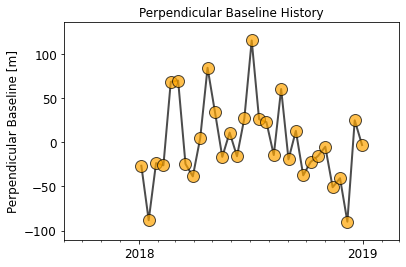

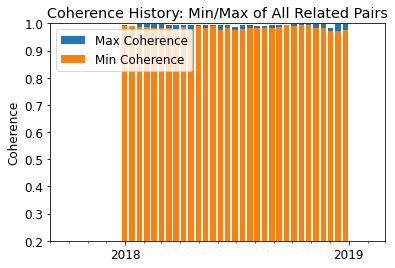

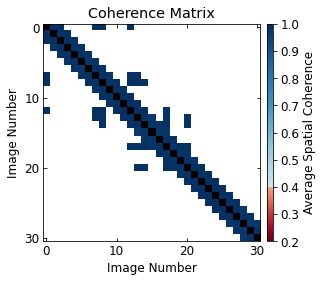

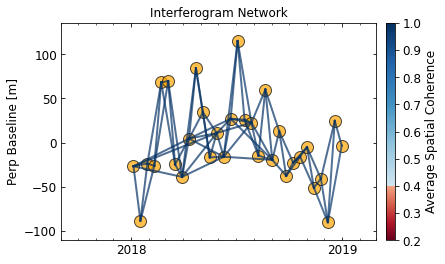

In [7]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)

plot_network.main(['inputs/ifgramStack.h5'])

<a id='secular_generate_mask'></a>
## 2.4. Generate Quality Control Mask


Mask files can be can be used to mask pixels in the time-series processing. Below we generate a mask file based on the connected components, which is a metric for unwrapping quality.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version v1.3.2-55, date 2022-05-02
input file is mask file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/maskConnComp.h5 in bool format
file size in y/x: (1129, 2677)
input dataset: "['mask']"
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']


maskConnComp.h5


data   coverage in y/x: (0, 0, 2677, 1129)
subset coverage in y/x: (0, 0, 2677, 1129)
data   coverage in lat/lon: (-116.620416667, 35.60125, -114.389584226, 34.660417043)
subset coverage in lat/lon: (-116.620416667, 35.60125, -114.389584226, 34.660417043)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [10.00, 3.37]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


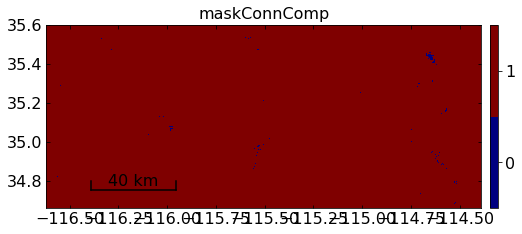

In [8]:
command='generate_mask.py inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update'
process = subprocess.run(command, shell=True)
view.main(['maskConnComp.h5', 'mask'])
msk_file = os.path.join(mintpy_dir, 'maskTempCoh.h5')

<a id='secular_common_latlon'></a>
## 2.5. Reference Interferograms To Common Lat/Lon


In [9]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, shell=True)
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:27.053981--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   direc

<a id='secular_invert_SBAS'></a>
## 2.6. Invert for SBAS Line-of-Sight Timeseries


In [10]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:31.292912--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      direct

<a id='secular_opt_correction'></a>
# 3. Optional Corrections

Phase distortions related to solid earth and ocean tidal effects, as well as those due to temporal variations in the vertical stratification of the atmosphere, can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

<a id='secular_solid_earth'></a>
## 3.1. Solid Earth Tide Correction

[MintPy provides functionality for this correction.]

<a id='secular_tropo_corr'></a>
## 3.2. Tropospheric Delay Correction

Optional atmospheric correction utilizes the PyAPS (Jolivet et al., 2011, Jolivet and Agram, 2012) module within GIAnT (or eventually a merged replacement for GIAnT and MintPy). PyAPS is well documented, maintained and can be freely downloaded. PyAPS is included in GIAnT distribution). PyAPS currently includes support for ECMWF’s ERA-Interim, NOAA’s NARR and NASA’s MERRA weather models. A final selection of atmospheric models to be used for operational NISAR processing will be done during Phase C.

[T]ropospheric delay maps are produced from atmospheric data provided by Global Atmospheric Models. This method aims to correct differential atmospheric delay correlated with the topography in interferometric phase measurements. Global Atmospheric Models (hereafter GAMs)... provide estimates of the air temperature, the atmospheric pressure and the humidity as a function of elevation on a coarse resolution latitude/longitude grid. In PyAPS, we use this 3D distribution of atmospheric variables to determine the atmospheric phase delay on each pixel of each interferogram.

The absolute atmospheric delay is computed at each SAR acquisition date. For a pixel a_i at an elevation z at acquisition date i, the four surrounding grid points are selected and the delays for their respective elevations are computed. The resulting delay at the pixel a_i is then the bilinear interpolation between the delays at the four grid points. Finally, we combine the absolute delay maps of the InSAR partner images to produce the differential delay maps used to correct the interferograms.

[MintPy provides functionality for this correction.]

In [11]:
do_tropo_correction = False
########################################################################
'''
REFERENCE : https://github.com/insarlab/pyaps#2-account-setup-for-era5
Read Section 2 for ERA5 [link above] to create an account on the CDS website.
'''

if do_tropo_correction:
    if not Use_Staged_Data and not os.path.exists(Path.home()/'.cdsapirc'):
        print('NEEDED to download ERA5, link: https://cds.climate.copernicus.eu/user/register')
        UID = input('Please type your CDS_UID:')
        CDS_API = input('Please type your CDS_API:')
        
        cds_tmp = '''url: https://cds.climate.copernicus.eu/api/v2
        key: {UID}:{CDS_API}'''.format(UID=UID, CDS_API=CDS_API)
        os.system('echo "{cds_tmp}" > ~/.cdsapirc; chmod 600 ~/.cdsapirc'.format(cds_tmp = str(cds_tmp)))
    
    command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_troposphere'
    process = subprocess.run(command, shell=True)
    
    view.main(['inputs/ERA5.h5'])
    timeseries_filename = 'timeseries_ERA5.h5'
else:
    timeseries_filename = 'timeseries.h5'

<a id='secular_phase_deramp'></a>
## 3.3. Phase Deramping


In [12]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep deramp'
process = subprocess.run(command, shell=True)

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:34.391788--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /Users/fielding/Downloads/A

<a id='topo_corr'></a>
## 3.4. Topographic Residual Correction 

[MintPy provides functionality for this correction.]

In [13]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_topography'
process = subprocess.run(command, shell=True)

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:37.123101--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /Users/fielding/Downloads/ATBD/work/s

<a id='secular_decomp_ts'></a>
# 4. Estimate InSAR and GNSS Velocities
The approach that will be used for the generation of NISAR L3 products for Requirements 660 and 663 allows for an explicit inclusion of key basis functions (e.g., Heaviside functions, secular rate, etc.) in the InSAR inversion. Modifications to this algorithm may be identified and implemented in response to NISAR Phase C activities. 

<a id='secular_insar_vel1'></a>
## 4.1. Estimate InSAR LOS Velocities

Given a time series of InSAR LOS displacements, the observations for a given pixel, $U(t)$, can be parameterized as:

$$U(t) = a \;+\; vt \;+\; c_1 cos (\omega_1t - \phi_{1,}) \;+\; c_2 cos (\omega_2t - \phi_2) \;+\; \sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;+\; \frac{B_\perp (t)}{R sin \theta}\delta z \;+\; residual$$ 

which includes a constant offset $(a)$, velocity $(v)$, and amplitudes $(c_j)$ and phases $(\phi_j)$ of annual $(\omega_1)$ and semiannual $(\omega_2)$ sinusoidal terms.  Where needed we can include additional complexity, such as coseismic and postseismic processes parameterized by Heaviside (step) functions $H$ and postseismic functions $F$ (the latter typically exponential and/or logarithmic).   $B_\perp(t)$, $R$, $\theta$, and $\delta z$ are, respectively, the perpendicular component of the interferometric baseline relative to the first date, slant range distance, incidence angle and topography error correction for the given pixel. 

Thus, given either an ensemble of interferograms or the output of SBAS (displacement vs. time), we can write the LSQ problem as 

$$ \textbf{G}\textbf{m} = \textbf{d}$$

where $\textbf{G}$ is the design matrix (constructed out of the different functional terms in Equation 2 evaluated either at the SAR image dates for SBAS output, or between the dates spanned by each pair for interferograms), $\textbf{m}$ is the vector of model parameters (the coefficients in Equation 2) and $\textbf{d}$ is the vector of observations.  For GPS time series, $\textbf{G}, \textbf{d}, \textbf{m}$ are constructed using values evaluated at single epochs corresponding to the GPS solution times, as for SBAS InSAR input. 

With this formulation, we can obtain InSAR velocity estimates and their formal uncertainties (including in areas where the expected answer is zero). 

The default InSAR velocity fit in MintPy is to estimate a mean linear velocity $(v)$ in in the equation, which we do below. 

In [14]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep velocity'
process = subprocess.run(command, shell=True)
vel_file = os.path.join(mintpy_dir, 'velocity.h5')
vel = readfile.read(vel_file, datasetName = 'velocity')[0] * 100.  #read and convert velocities from m to cm

# optionally set masked pixels to NaN
#msk = readfile.read(msk_file)[0]
#vel[msk == 0] = np.nan

MintPy version v1.3.2-55, date 2022-05-02
--RUN-at-2022-05-19 20:10:40.242218--
Current directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: MojaveD173
Go to work directory: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/MojaveD173.cfg
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/smallbaselineApp.cfg


*

Now we plot the mean linear velocity fit. The MintPy `view` module automatically reads the temporal coherence mask `maskTempCoh.h5` and applies that to mask out pixels with unreliable velocities (white).

run view.py in MintPy version v1.3.2-55, date 2022-05-02
input file is velocity file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/velocity.h5 in float32 format
file size in y/x: (1129, 2677)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 2677, 1129)
subset coverage in y/x: (0, 0, 2677, 1129)
data   coverage in lat/lon: (-116.620416667, 35.60125, -114.389584226, 34.660417043)
subset coverage in lat/lon: (-116.620416667, 35.60125, -114.389584226, 34.660417043)
------------------------------------------------------------------------
colormap: RdBu_r
figure title: LOS_Velocity
figure size : [10.00, 3.37]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 1450]
data    range: [-6.199871, 3.3383944] cm/year
display range: [-25.0, 25.0] cm/year
display data in trans

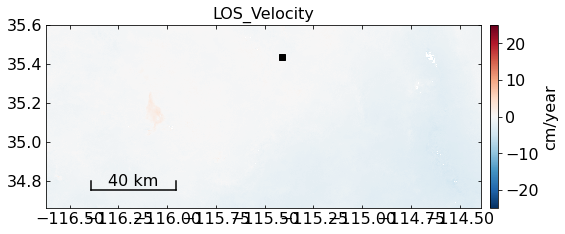

In [15]:
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 1450 --colormap RdBu_r --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

<a id='secular_co_gps'></a>
## 4.2. Find Collocated GNSS Stations

The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

In [16]:
# get analysis metadata from InSAR velocity file
atr = readfile.read_attribute(vel_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
lat_step = float(atr['Y_STEP'])
lon_step = float(atr['X_STEP'])
N = float(atr['Y_FIRST'])
W = float(atr['X_FIRST'])
S = N + lat_step * length
E = W + lon_step * width
start_date = atr.get('START_DATE', None)
end_date = atr.get('END_DATE', None)
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")
inc_angle = int(float(atr.get('incidenceAngle', None)))
az_angle = int(float(atr.get('azimuthAngle', None))) 

#Set GNSS Parameters
gps_completeness_threshold = 0.9     #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 10. #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

# search for collocated GNSS stations
site_names, site_lats, site_lons = gps.search_gps(SNWE=(S,N,W,E), 
                                                  start_date=start_date_gnss.strftime('%Y%m%d'),
                                                  end_date=end_date_gnss.strftime('%Y%m%d'))
site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

Initial list of 27 stations used in analysis:
['AZBH', 'AZFM', 'BKAP', 'CAB5', 'CDMT', 'GMRC', 'HCMN', 'HOME', 'I40A', 'LDSW', 'NDAP', 'NVLA', 'NVSL', 'NYOR', 'P603', 'P611', 'P614', 'P617', 'P618', 'P619', 'P621', 'P622', 'P625', 'P626', 'PIUT', 'RAGG', 'THUM']


<a id='secular_gps_ts'></a>
## 4.3. Get GNSS Position Time Series


In [17]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_lats = [] 
use_lons = []
counter = 0

for stn in site_names:
    gps_obj = gps.GPS(site = stn, data_dir = os.path.join(mintpy_dir,'GPS'))
    gps_obj.open(print_msg='False')
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss,end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    #disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, head_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days * gps_completeness_threshold <= gnss_count:
        if stn_stdv > gps_residual_stdev_threshold:
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_lats.append(site_lats[counter])
            use_lons.append(site_lons[counter])
    else:
        bad_stn.append(stn)
    counter+=1

site_names = use_stn
site_lats = use_lats
site_lons = use_lons

# [optional] manually remove additional stations
gnns_to_remove=[]

for i, gnss_site in enumerate(gnns_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)
    
print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)

calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

<a id='secular_gps_los'></a>
## 4.4. Make GNSS LOS Velocities


In [18]:
gps_comp = 'enu2los'

meta = readfile.read_attribute('velocity.h5')
SNWE = ut.four_corners(meta)

site_vels = gps.get_gps_los_obs(meta, 
                            'velocity', 
                            site_names, 
                            start_date=start_date,
                            end_date=end_date,
                            gps_comp=gps_comp, 
                            redo=True) * 100.
print('\n site   vel_los [cm/yr]')
print(np.array([site_names,site_vels]).T)

default GPS observation file name: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/gps_enu2los.csv
calculating GPS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 22/22 RAGG   10s /     0s 
write GPS observations to file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/gps_enu2los.csv

 site   vel_los [cm/yr]
[['AZBH' '-0.6009535']
 ['AZFM' '-0.7974174']
 ['BKAP' '-0.7720469']
 ['CAB5' '-0.9685604']
 ['CDMT' '-1.0048572']
 ['GMRC' '-0.7596313']
 ['HCMN' '-1.2026675']
 ['I40A' '-0.8055633']
 ['LDSW' '-1.0354811']
 ['NDAP' '-0.822332']
 ['NVLA' '-1.0571573']
 ['P603' '-0.8328029']
 ['P611' '-0.86513364']
 ['P614' '-0.7160854']
 ['P617' '-1.1150168']
 ['P618' '-0.96943825']
 ['P619' '-0.95771056']
 ['P621' '-0.810375']
 ['P622' '-1.1280761']
 ['P625' '-0.840145']
 ['P626' '-0.8022543']
 ['RAGG' '-1.0882974']]


<a id='secular_gps_insar'></a>
## 4.5. Re-Reference GNSS and InSAR LOS Velocities


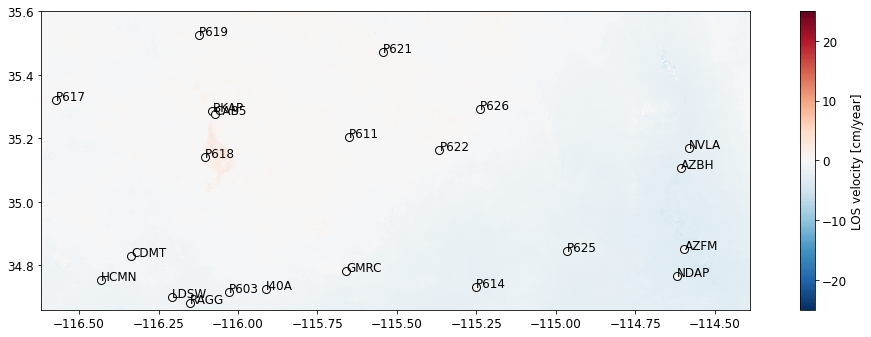

In [19]:
# reference GNSS stations to GNSS reference site
ref_site_ind = site_names.index(sites[site]['gps_ref_site_name'])
site_vels = site_vels - site_vels[ref_site_ind]

# reference InSAR to GNSS reference site
ref_site_lat = float(site_lats[ref_site_ind])
ref_site_lon = float(site_lons[ref_site_ind])
ref_y, ref_x = ut.coordinate(atr).geo2radar(ref_site_lat, ref_site_lon)[:2]
vel = vel - vel[ref_y, ref_x]

# plot GNSS stations on InSAR velocity field
vmin, vmax = -25, 25
cmap = plt.get_cmap('RdBu_r')

fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(vel, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS velocity [cm/year]')

for lat, lon, obs in zip(site_lats, site_lons, site_vels):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('vel_insar_vs_gnss.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<a id='secular_nisar_validation'></a>
# 5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison 


<a id='secular_make_vel'></a>
## 5.1. Make Velocity Residuals at GNSS Locations


In [20]:
#Set Parameters
pixel_radius = 5   #number of InSAR pixels to average for comparison with GNSS

#Create dictionary with the stations as the key and all their info as an array 
stn_dict = {}  

#Loop over GNSS station locations
for i in range(0,len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    vel_GPS = site_vels[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    vel_px_rad = vel[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    vel_InSAR = np.median(vel_px_rad)
    residual = vel_GPS - vel_InSAR

    # populate data structure
    values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_dict[stn] = values
    
# extract data from structure
res_list = []
insar_vel = []
gnss_vel = []
lat_list = []
lon_list = []
for i in range(len(site_names)): 
    stn = site_names[i]
    insar_vel.append(stn_dict[stn][2])
    gnss_vel.append(stn_dict[stn][3])
    res_list.append(stn_dict[stn][4])
    lat_list.append(stn_dict[stn][5])
    lon_list.append(stn_dict[stn][6])
num_stn = len(site_names) 
print('Finish creating InSAR residuals at GNSS sites')

Finish creating InSAR residuals at GNSS sites


<a id='secular_make_velres'></a>
## 5.2. Make Double-Differenced Velocity Residuals


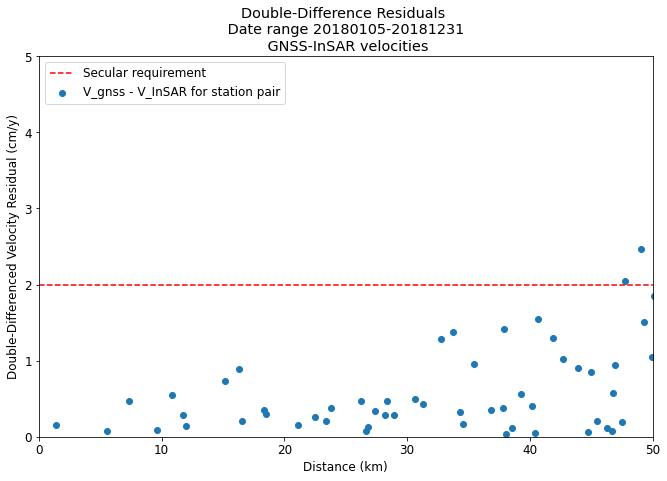

In [21]:
diff_res_list = []
stn_dist_list = []
dict_keys = list(stn_dict.keys())

# remove reference stn
site_names_analysis = list(site_names)
#site_names_analysis.remove(gps_ref_site_name)

# loop over stations
for i in range(len(site_names_analysis)-1):
    stn1 = dict_keys[i]
    for l in range(i + 1, len(dict_keys)):
        stn2 = dict_keys[l]

        # calculate between-station velocity residual
        # stn_dict values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]

        # calculate GNSS and InSAR velocity differences between stations
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        insar_vel_diff = stn_dict[stn1][2]-stn_dict[stn2][2]

        # calculate GNSS vs InSAR differences (double differences) between stations
        diff_res = gps_vel_diff - insar_vel_diff
        diff_res_list.append(diff_res)

        # get distance (km) between stations using Haversine formula
        # index 5 is lat, 6 is lon
        lat1 = stn_dict[stn1][5]*np.pi/180
        lat2 = stn_dict[stn2][5]*np.pi/180
        dlat = (lat2 - lat1)
        lon1 = stn_dict[stn1][6]*np.pi/180
        lon2 = stn_dict[stn2][6]*np.pi/180
        dlon = (lon2 - lon1)
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        c = 2*np.arctan2(np.sqrt(a),np.sqrt(1 - a))
        dist = 6371*c
        stn_dist_list.append(dist)

# Write data for statistical tests
dist = [np.array(stn_dist_list)]
rel_measure = [np.array(np.abs(diff_res_list))]
ifgs_date = np.array([[dt.strptime(start_date,"%Y%m%d"),dt.strptime(end_date,"%Y%m%d")]])
n_ifgs = len(dist)

# Plot data to be used below
fig, ax = plt.subplots(figsize=[11, 7])
plt.scatter(dist,rel_measure,label='V_gnss - V_InSAR for station pair')
plt.plot([0,200], [2, 2], 'r--',label='Secular requirement')
plt.ylim(0,5)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date}-{end_date} \n GNSS-InSAR velocities")
plt.xlabel("Distance (km)")
plt.ylabel("Double-Differenced Velocity Residual (cm/y)")
plt.show()

out_fig = os.path.abspath('secular_insar-gnss_velocity_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)


<div class="alert alert-warning">
Final result Method 1—Successful when 68% of points below requirements line
</div>


<a id='secular_valid_method1'></a>
## 5.3. Secular Requirement Validation: Method 1 table


In [22]:
# Calculate Statistics
n_bins = 10
threshold = 0.683  
#  we assume that the distribution of residuals is Gaussian and 
#  that the threshold represents a 1-sigma limit within which 
#  we expect 68.3% of residuals to lie.

bins = np.linspace(0.1, 50.0, num=n_bins+1)
n_all = np.empty([n_ifgs, n_bins+1], dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs, n_bins+1], dtype=int) # number of points pass

# the final column is the ratio as a whole
for i in range(n_ifgs):
    inds = np.digitize(dist[i], bins)
    for j in range(1, n_bins + 1):
        rqmt = 2 #3*(1+np.sqrt(dist[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = rel_measure[i][inds == j] # relative measurement
        #assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem < rqmt)
    n_all[i,-1] = np.sum(n_all[i, 0:-2])
    n_pass[i,-1] = np.sum(n_pass[i, 0:-2])
ratio = n_pass / n_all
success_or_fail = ratio > threshold

def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '
success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in range(len(ifgs_date)):
    index.append(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))
    
# Display Results

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

display(n_all_pd)  # Number of data points in each bin
display(n_pass_pd) # Number of data points that lie below the curve

#Set new style for table
s = ratio_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
display(s.set_td_classes(success_or_fail_pd))  # Percentage of passing points:
display(success_or_fail_pd)  # Explicit pass/fail table

# Overall pass/fail criterion
if n_ifgs == 1:
    if success_or_fail_pd.iloc[0]['total']:
        print("This velocity dataset passes the requirement.")
    else:
        print("This velocity dataset does not pass the requirement.")

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180105-20181231,1,3,3,5,4,7,6,7,8,10,44


,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180105-20181231,1,3,3,5,4,7,6,7,8,8,44


,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180105-20181231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000


,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180105-20181231,true,true,true,true,true,true,true,true,true,true,true


This velocity dataset passes the requirement.


<div class="alert alert-warning">
Final result Method 1 table by distance bin—successful when greater than 0.683
</div>


<a id='secular_nisar_validation2'></a>
# 6. NISAR Validation Approach 2: InSAR-only Structure Function

In Validation approach 2, we use a time interval and area where we assume no deformation.

In [23]:
os.chdir(mintpy_dir)  # reset directory in case running out of sequence
print(mintpy_dir)
# linear velocity fit when there was no earthquake
command = 'timeseries2velocity.py ' + timeseries_filename #+ ' --step ' + sites[site]['noEarthquakeDate']
process = subprocess.run(command, shell=True)

/Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy
open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 31
['20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
------------

velocity.h5


run view.py in MintPy version v1.3.2-55, date 2022-05-02
input file is velocity file: /Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/velocity.h5 in float32 format
file size in y/x: (1129, 2677)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 2677, 1129)
subset coverage in y/x: (0, 0, 2677, 1129)
data   coverage in lat/lon: (-116.620416667, 35.60125, -114.389584226, 34.660417043)
subset coverage in lat/lon: (-116.620416667, 35.60125, -114.389584226, 34.660417043)
------------------------------------------------------------------------
colormap: RdBu_r
figure title: LOS_Velocity
figure size : [10.00, 3.37]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 1450]
data    range: [-6.199871, 3.3383944] cm/year
display range: [-25.0, 25.0] cm/year
display data in trans

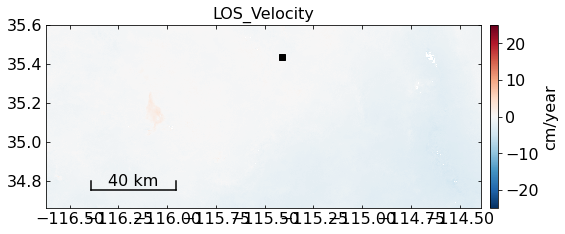

In [24]:
# plot velocity map
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 1450 --colormap RdBu_r --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

### 6.1 Read array and mask pixels with no data

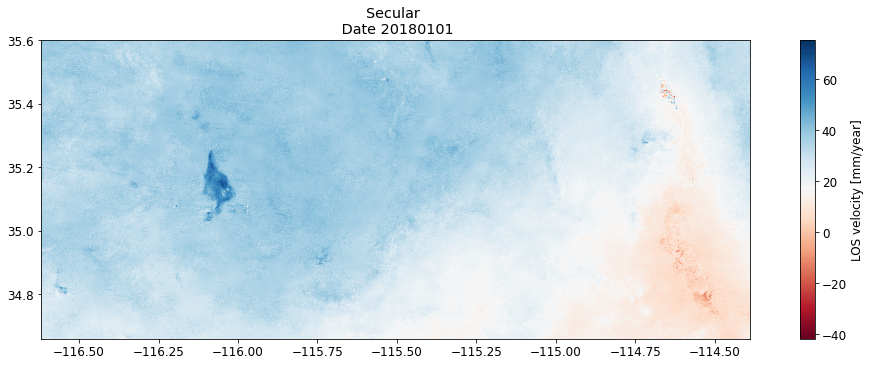

In [25]:
# use the assumed non-earthquake displacement as the insar_displacment for statistics and convert to mm
noEQvel,atrib = readfile.read(vel_file, datasetName = 'velocity')  #read velocity 
velStart = sites[site]['download_start_date']
insar_displacement = noEQvel[np.newaxis, :] * 1000. # convert from m to mm and add dimension to array to allow multiple datasets

ifgs_date = np.array([velStart])  # only one secular date for now
#print(insar_displacement.shape)
n_ifgs = insar_displacement.shape[0]

# # mask out no-data areas
insar_displacement[insar_displacement == 0] = np.nan

# # display map of data after masking
cmap = plt.get_cmap('RdBu')
for i in range(n_ifgs):
     fig, ax = plt.subplots(figsize=[18, 5.5])
     img1 = ax.imshow(insar_displacement[i], cmap=cmap, interpolation='nearest', extent=(W, E, S, N))
     ax.set_title("Secular \n Date "+velStart)
     cbar1 = fig.colorbar(img1, ax=ax)
     cbar1.set_label('LOS velocity [mm/year]')


### 6.2 Randomly Sample Pixels and Pair Them Up with Option to Remove Trend

In [26]:
X0,Y0 = load_geo(atrib)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

M2dist = []; rel_measure = []
for i in range(n_ifgs):
     dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,insar_displacement[i],num_samples=1000000)
     M2dist.append(dist_i)
     rel_measure.append(rel_measure_i)

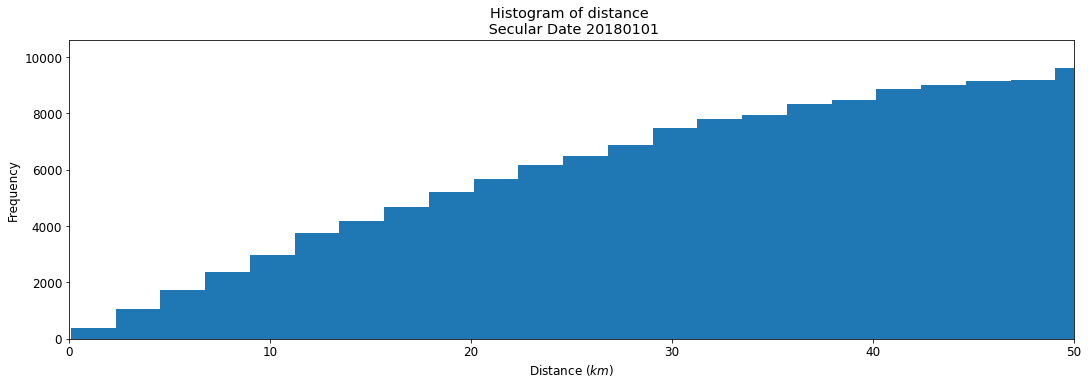

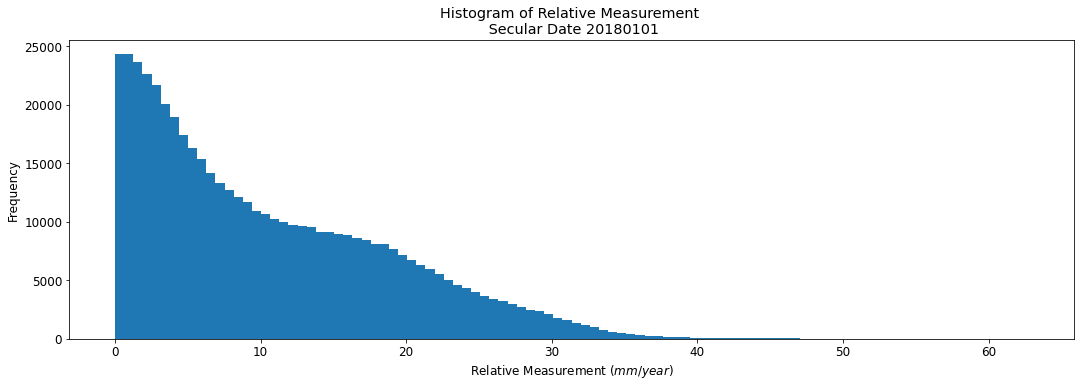

In [27]:
for i in range(n_ifgs):
     fig, ax = plt.subplots(figsize=[18, 5.5])
     img1 = ax.hist(M2dist[i], bins=100)
     ax.set_title(f"Histogram of distance \n Secular Date "+velStart)
     ax.set_xlabel(r'Distance ($km$)')
     ax.set_ylabel('Frequency')
     ax.set_xlim(0,50)
    
for i in range(n_ifgs):
     fig, ax = plt.subplots(figsize=[18, 5.5])
     img1 = ax.hist(rel_measure[i], bins=100)
     ax.set_title(f"Histogram of Relative Measurement \n Secular Date "+velStart)
     ax.set_xlabel(r'Relative Measurement ($mm/year$)')
     ax.set_ylabel('Frequency')

<a id='M2ampvsdist2'></a>
## 6.3. Amplitude vs. Distance of Relative Measurements (pair differences)


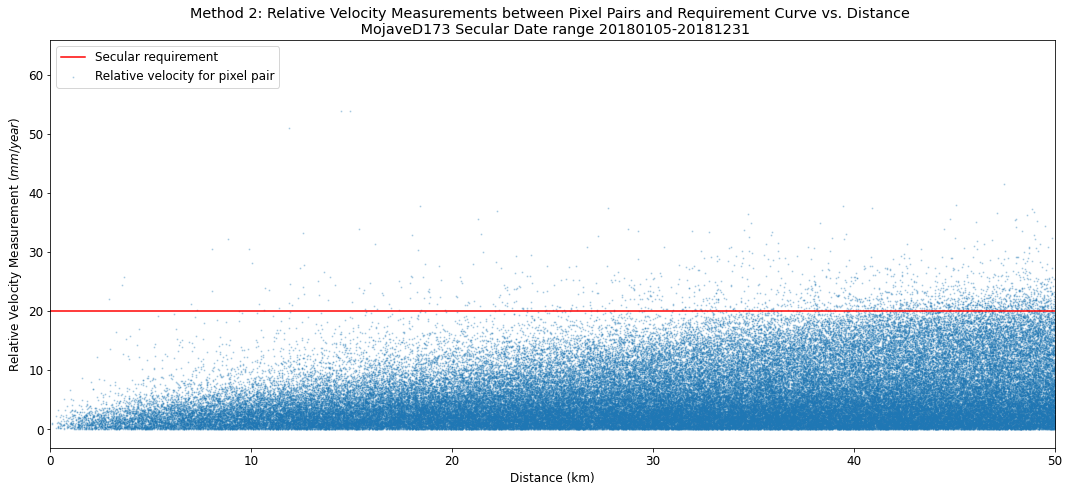

In [28]:
dist_th = np.linspace(0,50,100)  # distance in km
rqmt = 20*(1+0.0*(dist_th))   # secular requirement in mm/year
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 7.5])
    ax.plot(dist_th, rqmt, 'r',label='Secular requirement')
    ax.scatter(M2dist[i], rel_measure[i], s=1, alpha=0.25, label='Relative velocity for pixel pair')
    ax.set_title(f"Method 2: Relative Velocity Measurements between Pixel Pairs and Requirement Curve vs. Distance \n {site} Secular Date range {start_date}-{end_date}" )
    ax.set_ylabel(r'Relative Velocity Measurement ($mm/year$)')
    ax.set_xlabel('Distance (km)')
    ax.set_xlim(0,50)
    plt.legend(loc='upper left')

    
    plt.show()

    out_fig = os.path.abspath('secular_insar-only_vs_distance_'+site+'_date'+velStart+'.png')
    fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<div class="alert alert-warning">
Final result Method 2—
    68% of points below the requirements line is success
</div>


In [29]:
with open(work_dir/'approach2.pkl','wb') as f:
     pickle.dump((M2dist,rel_measure,ifgs_date),f)

<a id='M2RelMeasTable'></a>
## 6.4 Bin sample pairs by distance bin and calculate statistics

In [30]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
#ratio = np.empty([n_ifgs,n_bins+1]) # ratio
# the final column is the ratio as a whole
for i in range(n_ifgs):
    inds = np.digitize(M2dist[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 20*(1+0.0*(M2dist[i][inds==j])) # Secular mission requirement constant (mm/year)
        rem = rel_measure[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])
    
ratio = n_pass/n_all
mean_ratio = np.array([np.mean(ratio[:,:-1],axis=1)])
ratio = np.hstack((ratio,mean_ratio.T))
thresthod = 0.683
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod
success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

# make table

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in range(len(ifgs_date)):
    index.append(ifgs_date[i])
    
n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns+['mean'],index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns+['mean'],index=index)

In [31]:
n_all_pd

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180101,1859,5150,8339,10846,13342,15356,17427,18712,20021,20647,111052


In [32]:
n_pass_pd

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180101,1856,5143,8315,10808,13278,15263,17276,18486,19583,19883,110008


In [33]:
s = ratio_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
s.set_td_classes(success_or_fail_pd)

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total,mean
20180101,0.998386,0.998641,0.997122,0.996496,0.995203,0.993944,0.991335,0.987922,0.978123,0.962997,0.990599,0.990017


<div class="alert alert-warning">
Final result Method 2 table of distance bins—
    68% (0.683) of points below the requirements line is success
</div>


In [34]:
np.count_nonzero(ratio_pd['total']>threshold)/n_ifgs

1.0

<a id='secular_appendix1'></a>
# 7. Appendix: Supplementary Comparisons and Plots

<a id='secular_compare_raw'></a>
## 7.1. Compare Raw Velocities


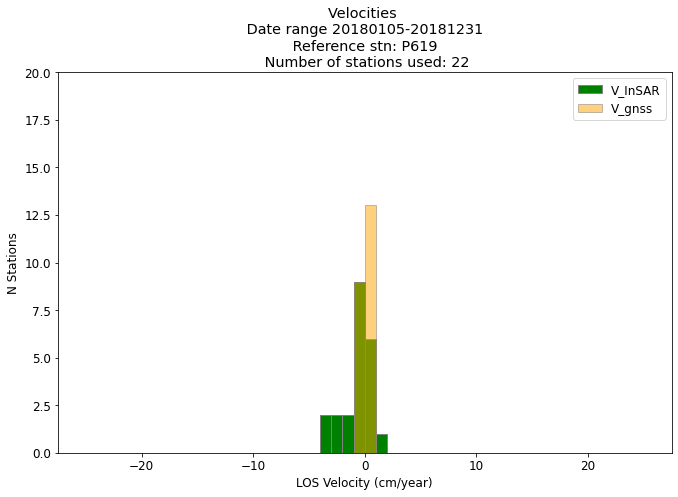

In [35]:
vmin, vmax = -25, 25
plt.figure(figsize=(11,7))
plt.hist(insar_vel, range = [vmin, vmax],bins = 50, color = "green",edgecolor='grey',label='V_InSAR')
plt.hist(gnss_vel, range = [vmin, vmax],bins = 50, color = "orange",edgecolor='grey',label='V_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f"Velocities \n Date range {start_date}-{end_date} \n Reference stn: {sites[site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('LOS Velocity (cm/year)')
plt.ylabel('N Stations')
plt.ylim(0,20)
plt.show()

<a id='secular_plot_vel'></a>
## 7.2. Plot Velocity Residuals


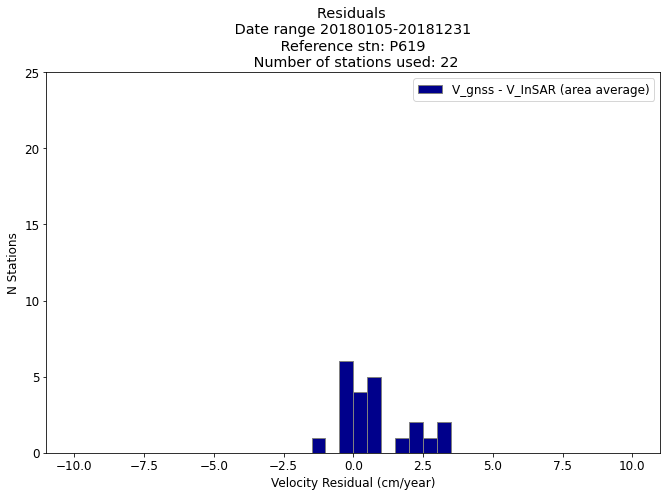

In [36]:
vmin, vmax = -10, 10
plt.figure(figsize=(11,7))
plt.hist(res_list,bins = 40, range = [vmin, vmax],edgecolor='grey',color="darkblue",linewidth=1,label='V_gnss - V_InSAR (area average)')
plt.legend(loc='upper right')
plt.title(f"Residuals \n Date range {start_date}-{end_date} \n Reference stn: {sites[site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('Velocity Residual (cm/year)')
plt.ylabel('N Stations')
plt.ylim(0,25)
plt.show()

<a id='secular_plot_velres'></a>
## 7.3. Plot Double Difference Residuals


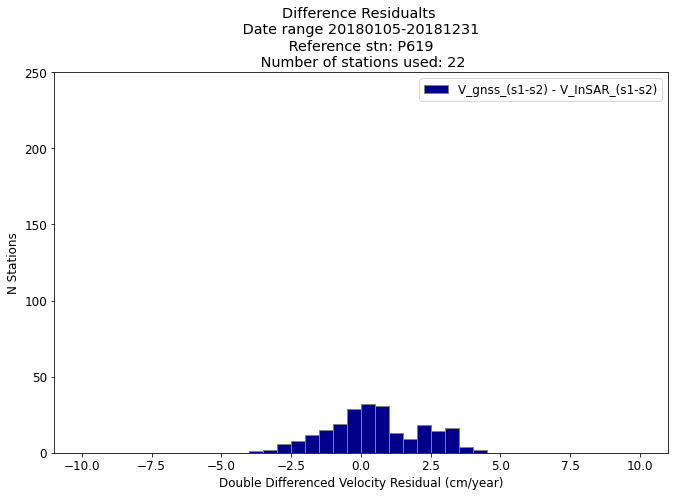

In [37]:
plt.figure(figsize=(11,7))
plt.hist(diff_res_list, range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',label='V_gnss_(s1-s2) - V_InSAR_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f"Difference Residualts \n Date range {start_date}-{end_date} \n Reference stn: {sites[site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('Double Differenced Velocity Residual (cm/year)')
plt.ylabel('N Stations')
plt.ylim(0,250)
plt.show()

<a id='secular_appendix_gps'></a>
## 7.4. GNSS Timeseries Plots


/Users/fielding/Downloads/ATBD/work/secular_ouputs/MojaveD173/MintPy/timeseries.h5
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calcula

/var/folders/92/tx_tbh3d05x_gpx6ydy5nmd94bbnb9/T/ipykernel_5803/2393999795.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))


calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction


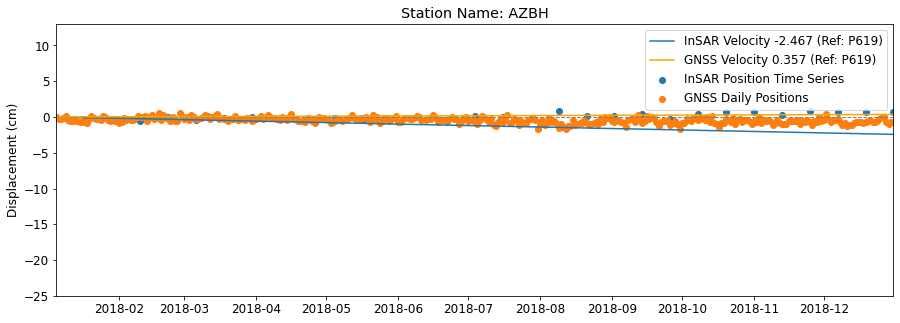

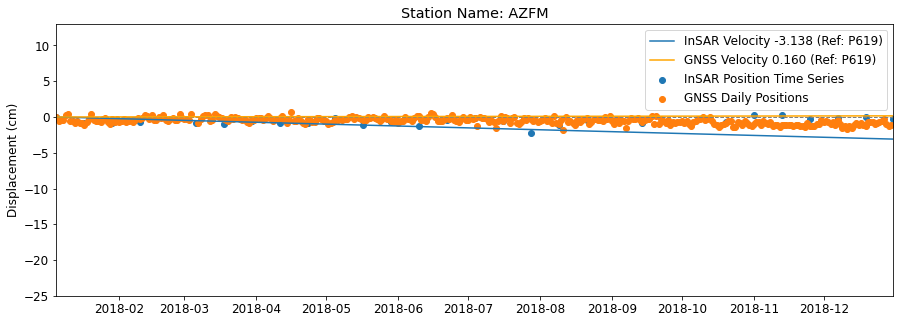

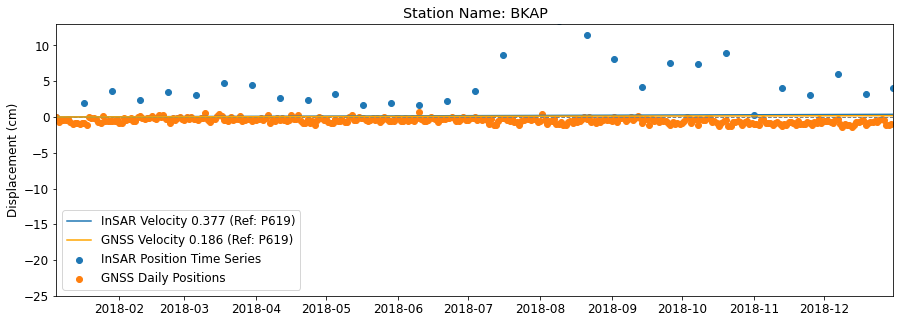

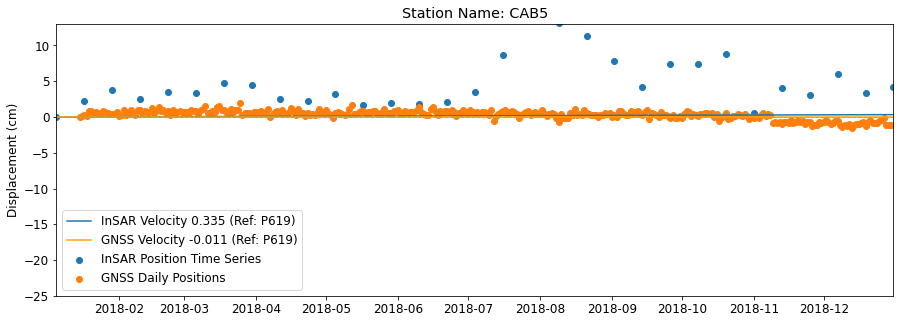

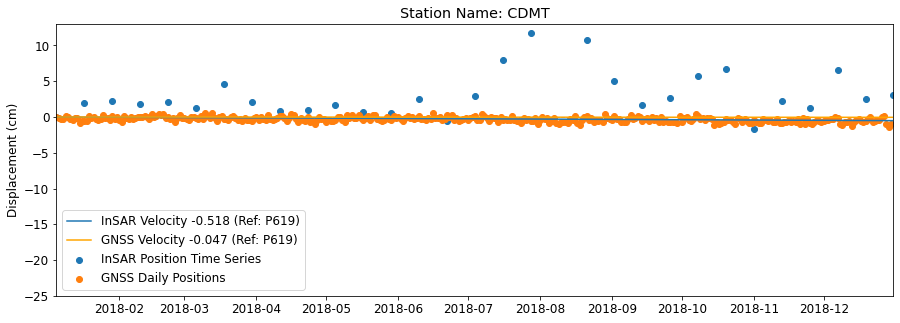

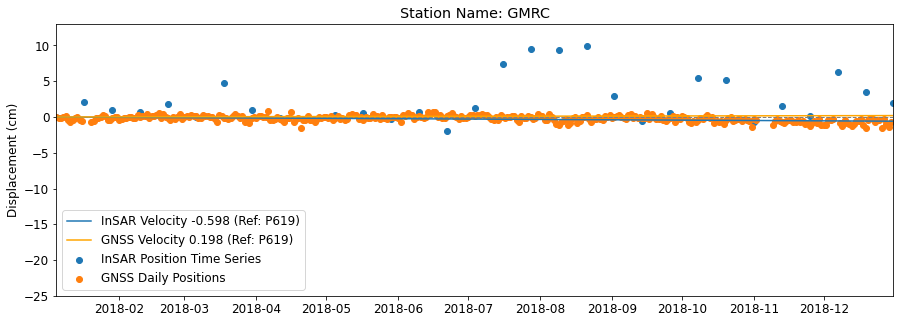

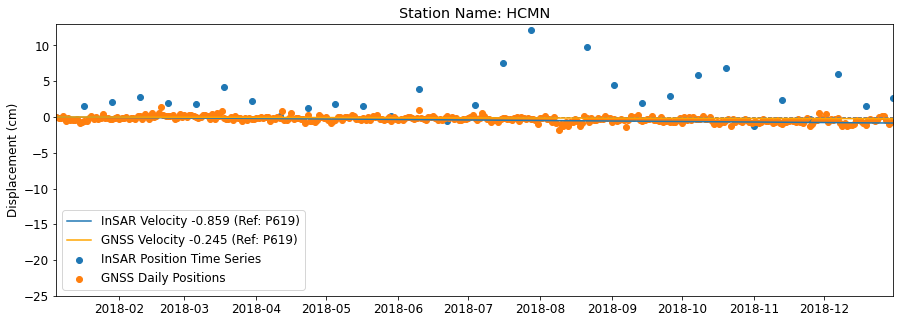

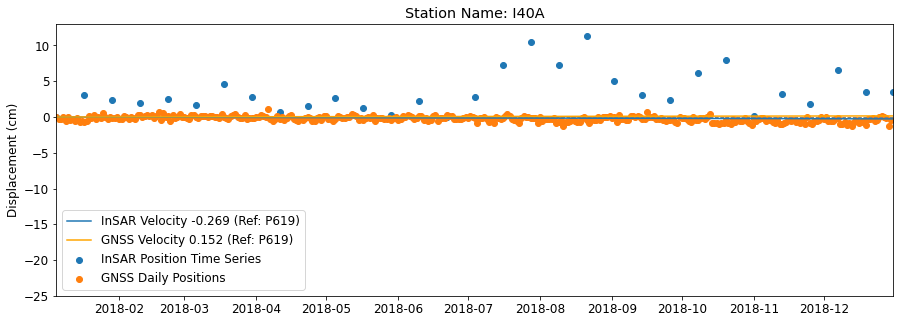

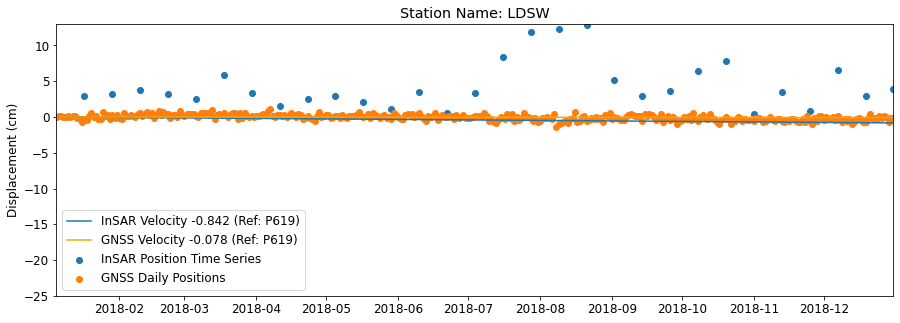

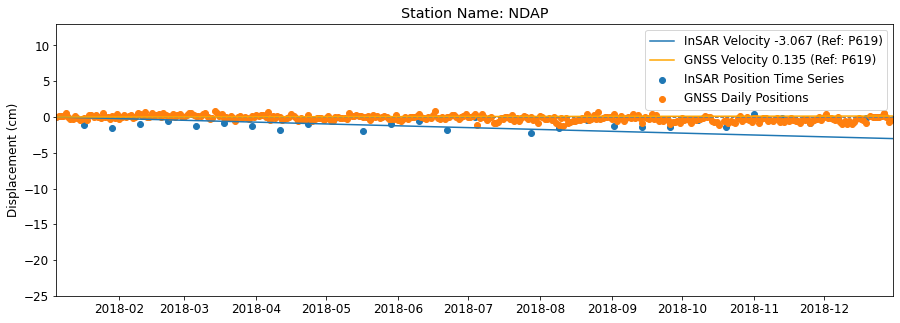

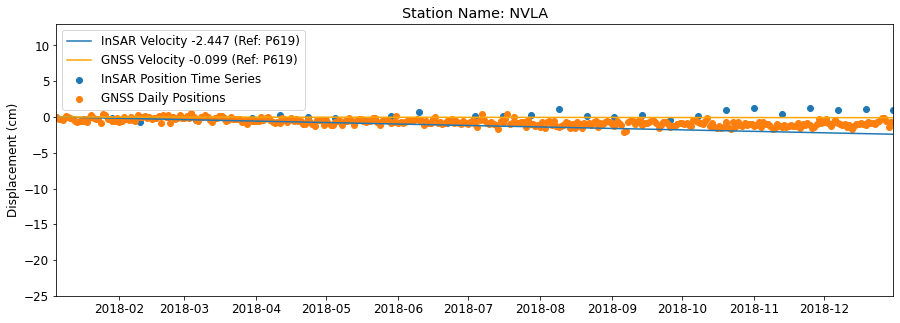

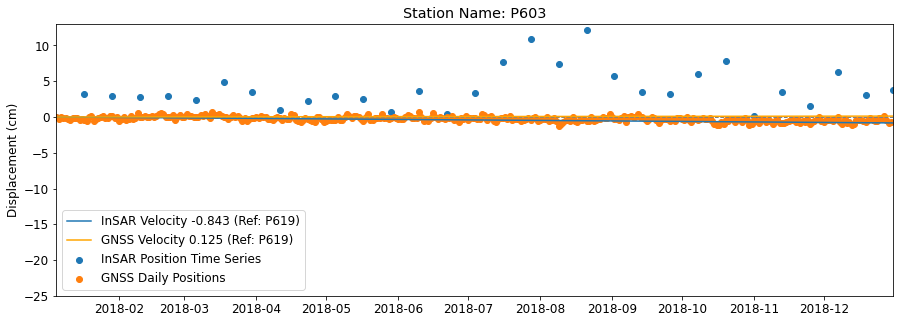

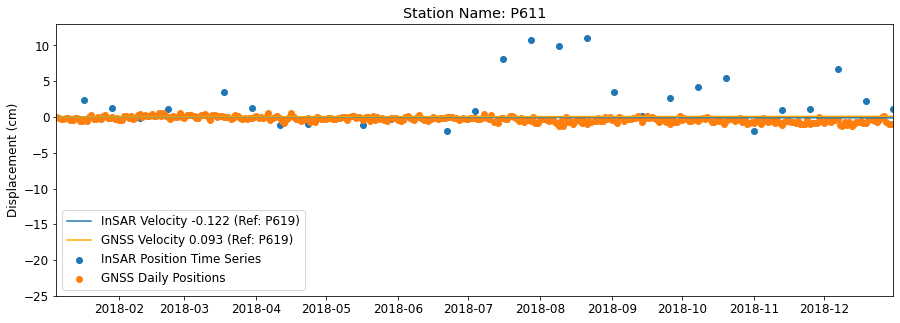

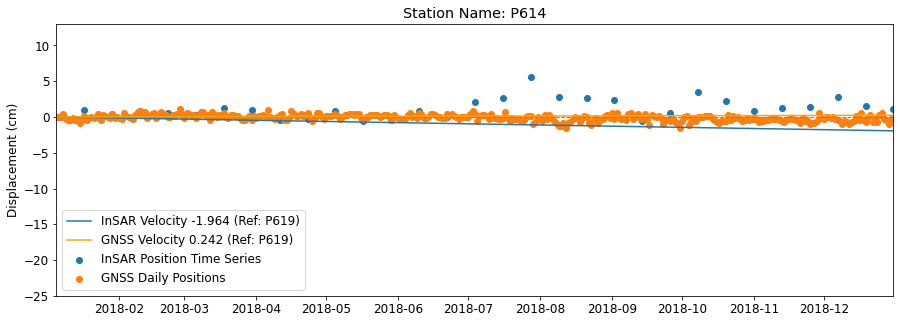

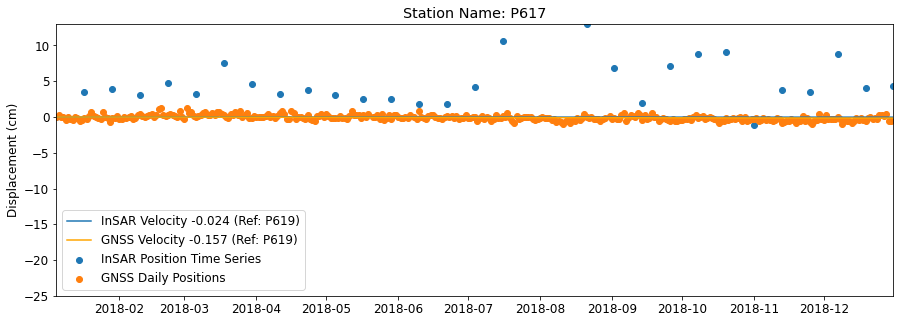

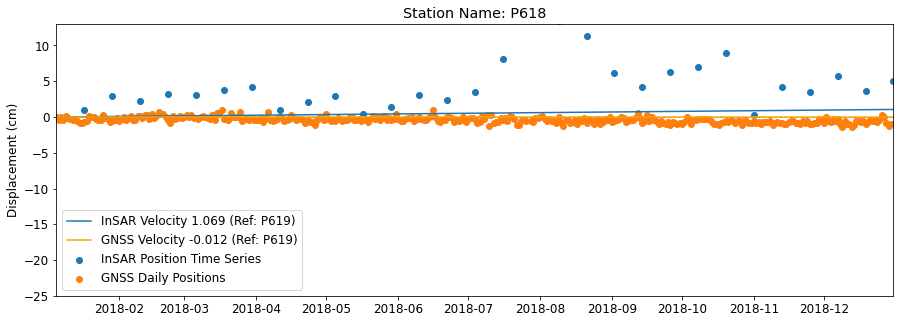

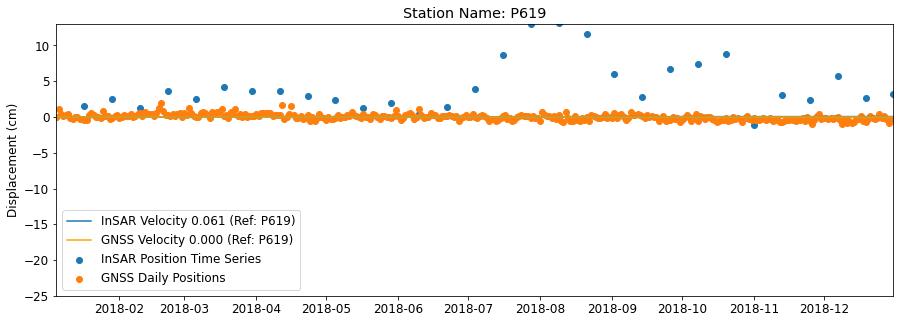

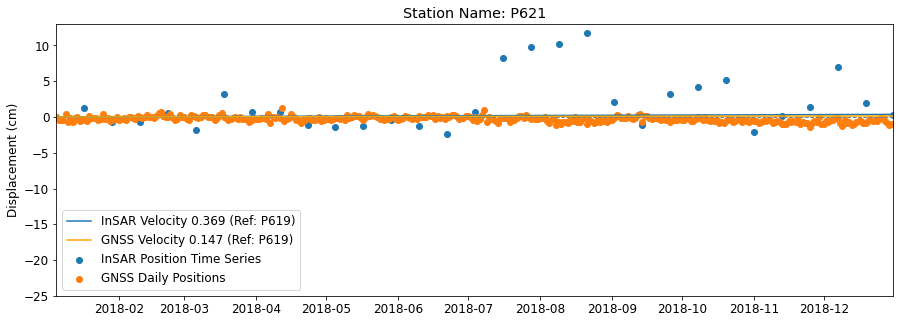

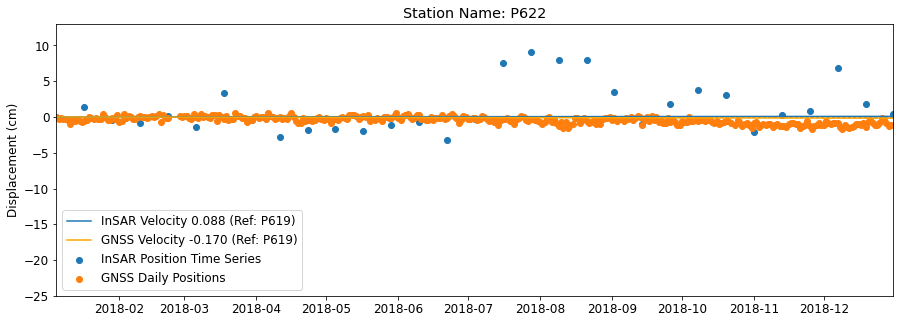

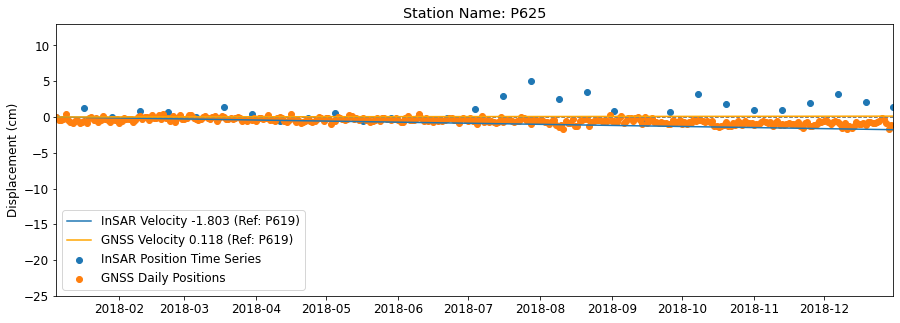

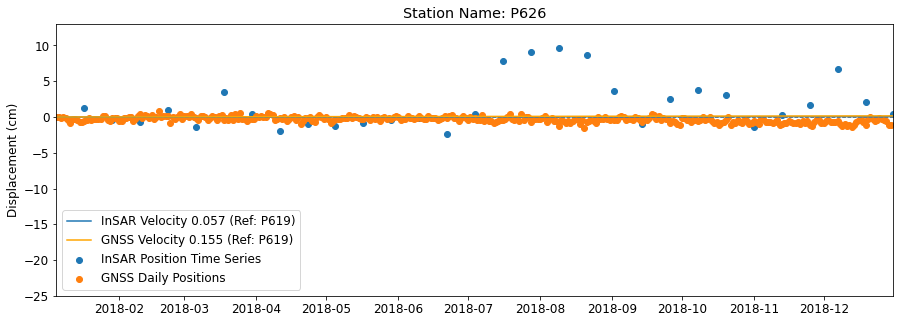

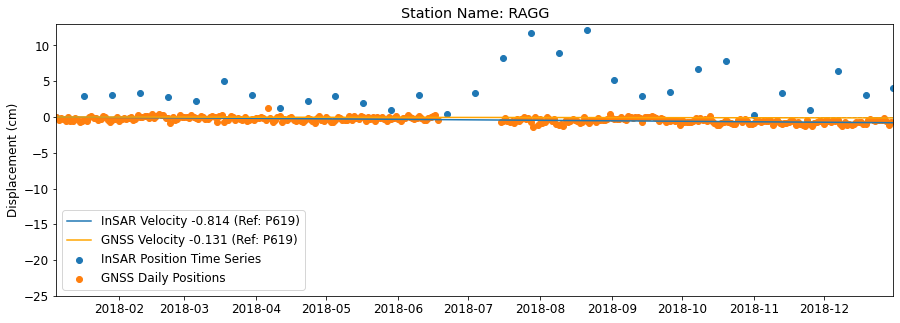

In [38]:
time_file = os.path.join(work_dir, 'MintPy/timeseries.h5')
insar_displacements = readfile.read(time_file, datasetName='timeseries')[0] * 100.
print(time_file)
#Get aquisition dates, trim the str, and convert to datetime
raw_aqu_list = readfile.get_slice_list(time_file)
acquisitions_dates = []
for i in range(len(raw_aqu_list)):
    date = raw_aqu_list[i].split("-")
    #aqu_dates.append = date[1]
    acquisitions_dates.append(dt.strptime(date[1], "%Y%m%d"))
ndates = len(acquisitions_dates)

#Plot displacements and velocity timeseries at GNSS station locations
#test_list = site_names
# test_list = ['CAHA', 'CAKC', 'CAND', 'CARH'] #for testing, remove after
test_list = site_names
for stn in test_list:
    
    #InSAR Info
    insar_timeseries = []
    stn_x = (stn_dict[stn][0])
    stn_y = (stn_dict[stn][1])
    for i in range(ndates):
        insar_displacement = insar_displacements[i,stn_y,stn_x]
        insar_timeseries.append(insar_displacement)     
    InSAR_stn_vel = stn_dict[stn][2]
    GNSS_stn_vel = stn_dict[stn][3]
    #print(InSAR_stn_vel)
    #print(GNSS_stn_vel)
    
    #get the length of time between first and last interferogram for velocity plotting
    insar_timespan = acquisitions_dates[ndates - 1] - acquisitions_dates[0]
    conversion = insar_timespan.days/365.25
    aqu_dates_convert=acquisitions_dates #/conversion
   
    #Plot InSAR
    plt.figure(figsize=(15,5))  
    plt.plot([0,100000],[0,0], color='grey',linestyle='dashed',linewidth=1)
    plt.scatter(acquisitions_dates, insar_timeseries, label="InSAR Position Time Series")
    #velocity trendline
    plt.plot([acquisitions_dates[0], acquisitions_dates[ndates - 1]],[0,conversion*InSAR_stn_vel],label=f"InSAR Velocity {InSAR_stn_vel:.3f} (Ref: {sites[site]['gps_ref_site_name']})")

    #GNSS Info
    gps_obj = gps.GPS(site = stn, data_dir = mintpy_dir/'GPS')
    gps_obj.open()
    dates = gps_obj.dates
    head_angle = 90 - az_angle
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, head_angle, az_angle)

    #Plot GNSS
    index_begin = np.min(np.where(dates >= start_date_gnss))
    index_end = np.max(np.where(dates <= end_date_gnss))

    dates_cut = dates[index_begin:index_end]
    disp_los_cut = disp_los[index_begin:index_end]
    disp_los_cut = (disp_los_cut - np.median(disp_los_cut))*100
    plt.scatter(dates_cut, disp_los_cut - disp_los_cut[0], label="GNSS Daily Positions")   
    #velocity trendline
    plt.plot([acquisitions_dates[0], acquisitions_dates[ndates - 1]],[0,conversion*GNSS_stn_vel],color='orange',label=f"GNSS Velocity {GNSS_stn_vel:.3f} (Ref: {sites[site]['gps_ref_site_name']})")

    plt.title(f"Station Name: {stn}") 
    plt.ylabel('Displacement (cm)')
    plt.ylim(-25,13)
    plt.xlim
    plt.xlim(aqu_dates_convert[0],aqu_dates_convert[ndates - 1])
    plt.legend(loc="best")  